# Depth estimation with DepthAnything and OpenVINO

[Depth Anything](https://depth-anything.github.io/) is a highly practical solution for robust monocular depth estimation. Without pursuing novel technical modules, this project aims to build a simple yet powerful foundation model dealing with any images under any circumstances.
The framework of Depth Anything is shown below. it adopts a standard pipeline to unleashing the power of large-scale unlabeled images.
![image.png](https://depth-anything.github.io/static/images/pipeline.png)

More details about model can be found in [project web page](https://depth-anything.github.io/), [paper](https://arxiv.org/abs/2401.10891) and official [repository](https://github.com/LiheYoung/Depth-Anything)

In this tutorial we will explore how to convert and run DepthAnything using OpenVINO. An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up the model.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load and run PyTorch model](#Load-and-run-PyTorch-model)
    - [Prepare input data](#Prepare-input-data)
    - [Run model inference](#Run-model-inference)
- [Convert Model to OpenVINO IR format](#Convert-Model-to-OpenVINO-IR-format)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Run inference on image](#Run-inference-on-image)
    - [Run inference on video](#Run-inference-on-video)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
    - [Compare model file size](#Compare-UNet-file-size)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/depth-anything/depth-anything.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import requests
from pathlib import Path

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

In [2]:
from cmd_helper import clone_repo

repo_dir = clone_repo("https://github.com/LiheYoung/Depth-Anything")

%cd $repo_dir

/content/Depth-Anything


In [3]:
import platform


%pip install -q "openvino>=2023.3.0" "datasets>=2.14.6" "nncf" "tqdm"
%pip install -q "typing-extensions>=4.9.0" eval-type-backport "gradio>=4.19" "matplotlib>=3.4"
%pip install -q torch torchvision "opencv-python" huggingface_hub --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"
if platform.python_version_tuple()[1] in ["8", "9"]:
    %pip install -q "gradio-imageslider<=0.0.17" "typing-extensions>=4.9.0"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load and run PyTorch model
[back to top ⬆️](#Table-of-contents:)

To be able run PyTorch model on CPU, we should disable xformers attention optimizations first.

In [4]:
from pathlib import Path

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("depth-anything.ipynb")


attention_file_path = Path("./torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py")
orig_attention_path = attention_file_path.parent / ("orig_" + attention_file_path.name)

if not orig_attention_path.exists():
    attention_file_path.rename(orig_attention_path)

    with orig_attention_path.open("r") as f:
        data = f.read()
        data = data.replace("XFORMERS_AVAILABLE = True", "XFORMERS_AVAILABLE = False")
        with attention_file_path.open("w") as out_f:
            out_f.write(data)

`DepthAnything.from_pretrained` method creates PyTorch model class instance and load model weights. There are 3 available models in repository depends on VIT encoder size:
* Depth-Anything-ViT-Small (24.8M)
* Depth-Anything-ViT-Base (97.5M)
* Depth-Anything-ViT-Large (335.3M)

We will use `Depth-Anything-ViT-Small`, but the same steps for running model and converting to OpenVINO are applicable for other models from DepthAnything family.

In [5]:
from depth_anything.dpt import DepthAnything

encoder = "vits"  # can also be 'vitb' or 'vitl'
model_id = "depth_anything_{:}14".format(encoder)
depth_anything = DepthAnything.from_pretrained(f"LiheYoung/{model_id}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from PIL import Image

from notebook_utils import download_file, device_widget, quantization_widget

if not Path("furseal.png").exists():
    download_file(
        "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUSExMVFRUVGBcVFRcVFRUVGBUVFRUXFhUVFxUYHSggGBolHRUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OFhAQFy0dHx0tLS0tLS0tKy0tLSstLSstLSstLS0tLS0tLS0tLS0rKy0rLS0tKy0tKy0tMisvLSstL//AABEIALcBEwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAAIDBQYBBwj/xABEEAABAwIDBAcFBAgDCQAAAAABAAIDBBEFEiExQVFhBhMicYGRoTJSscHRFELh8AczYnKCkrLxI5OiFRYkRFRzg4TC/8QAGgEBAQEBAQEBAAAAAAAAAAAAAAECAwQFBv/EACcRAQEAAgEDAgYDAQAAAAAAAAABAhEDBBIhMUEFE2FxwfCx0eGh/9oADAMBAAIRAxEAPwC8zroeoA5dzLs5s704xDKwM46n8/narXoQWxwtladTnzEkfd7bWDgXNdv3jyxXSifrJiNw08vyEd0axJozQym0cgym9zkcNWvHdre2tj+yvFyck7tPvdL0mV6W5ye/7+G7GMA6XcTctOZoGzZYjQi3HXVTF2bZ8RrpsF96zlVQPbqRa1gDms1wt2XNO/TeOAR+DuLTZ4blOx4jZI9umwvcLtZt2HeVHm3pPTB561z2ZQzMA1twLNs7QA6k3GoNtNizvTTGi+CJhjDSXl9gfutbbeTc67eFuC9DlqGRwmQkAEEkkttmabHRlmnXbYEc77fK6WRtZXB1rQxdoDtG7GG4Bvc9pxF77r8FdedO3S47y776YiMTpuooctrPfldJyJcHBh7gG+ObiqvopMSyRpIGYBo1tqb6d6uelz80D3HNfs7Tpq4fisXhz3NOdhs4HS/cFy6vj+Zx3GPX0mN5OXXv5/hvMDrDBI1sgLc4DTmFtfunmN1/2rqyxqssNGu8LDYfevxtu3hZKm6QS2sWggeXg3Z6JkuLudsDAe5t78dmi/P5dDnly91n38vqz4fya8WaanD6yGnh6wn2iS4aC5A0G3Ru4AXWOxfEHVEpe7uA90cLcdB3BDz1eY3c4uP537vBCuc4nhbcNF7+l6Hszud9a7TDi6abuUt+n7/pOpnHUm3ipGBwNy+43AD4lWGE4DU1P6mF7x72gZ/mPsD4LT0X6M6h2sssUfJodKfM5QPVfUnBllPLw5/FOn4bbjbb9/6/LFGXl63+CXWH3fT6r0+m/RpAPbmnfyBjjHkGk+qOg6C0DP8Al8//AHHySejnW9F0x6aR4uX4/cvEm/8AjyA11vayjmXAeimina/Rvb5Na55/0he10uDU0X6unhZzbEwHztdHZyBYGw5aLfyMXky+Oc/t+/w8NZhNQ/2IKg/+tNb+YssrnC+hk73Az/4bBtuWl1v2WNJ17yB37F6fK9BSlanDh6vPyfF+pzlx7tb+5sYa1rWMGVjWhrBwaPid5PElOc5D5rG3HUfMJxfouz5du0gepWvQjipGPURawVV7A7US1ypo5LHmEY+oIbmtfiirFr1K2VAQTBwuERdAY05hcC/veGl1URYYQ+oYT/hzZZGneyUANd/SxwPG6HxszCNxg9odrL7wO0Dn2SUF0d6TmR4gl/WG9iOLdS13A21U3pfVqMHrjLEC7R7SWSDhIw2d4HaORCMJWZZN1NaB9yrbpyniHxcz+hXdVUtjY6R5ysaC5zjsAG0lNGxJA4JLK/780e50pG4iCWx7tEkNs+0pzth7k1gUzBqtDymveXSP0vqePEpsYLfwNu4gnYVddLcCNPO4kf4chLo32uHA62vuI2WVGGt4/wCkfNeDPjttfr+h6rhx4cfOvH77NDhvSiaFuWwkjH3XAOAvt7N7t/hIBR8fTrKCBANeJuB3DaPNZDrWjf8A0hNM7OF/EH4BTHDM5suhyvd/f4WuM9I5ajsuNmD7jbNHkrzotT9VAXkdqo02bImnTX9p2vgFlqKAyvYxsbu05rb5Xm2YgXJ8V6TU07vZA7OgaBuDRYd2i7Ycd9Xk5us4ZjMML4+kUfSl3/DOFtTlv4OubLEUhN7fHy+i9ExPDZHMN26W17kJhX6PHPAc+XLm1sGXIvsBJNr+C1eO2aePi63Hi5e+MpJLa4AtzvbyQ+Tifz3leqU36OqVntvkd4hv9ACsMP6K05daGFuh1kcM2XuLrknksYdNMXu6j49eS+J/jy/CcDnqCGxRk336gd+Y7u669L6Ofo7his+e0rxrl+4D+7v8braUOHsiFmjvcdru8/JFBi7zGT0fG5+t5OX1oZkIAsBYDYAnCJFBi6GKvIEMSY+BH5FxzERUOjQ8is52KunCoBmKDkciJ3KvlKrNNmN9PJcikv37xzTmqGUEHMPEcRy5j68kEwO7gk19lEx4Oo1ScUQWXb/PuT21DhsQ0Uie19jby+iEFU1QWnYLHareJ1xdUYF9mh4I6gfx7lNtD36Obzu35j4HzQ9Lh8LHulawdY4kl1tbG2l/PzU9X7Fxu1H8OvyQM2ItjeWvNgbFul9D/ZVFfj8onzRMuyaJwkhcTtkZqO4EGx5FRdM5w/DAQSOuMLDc6jNI3OCOIsQpsbwwyOE0ThcAZhexNtjgeNvgs5iHRSCon1qpQ62aSNoH6zeY7mw56KitkjDTbOBbdZdWmj6J0thmNQ47yXjX0SU1We0yNilDFIyNTMjWmjALtLHAOadrXAOHkUH/ALEp/wDp4f8ALarVkKmECiy2KuHB4BsgiH/jb9EXHQsGxjR3NA+CNbEpGxoboaGn13924J7oRfZs2IxsVto1Uc0gaCSooKrpw6zTs2u5gbvH4XRLqhrBdV/XOedPT4K4oMJ1DpNTuG4d/FFRUdFJOQ55LI9w3u+g5rRQRtY0NaAANgC40JxCgWZdDlGIiVKymUDwngJNjsnhqg5ZNcE8qGaSyASqKqKp6Mq5lT1MyqBqh6BkcppnIR7lWUrXJxcoGuTg5APJC4G7CObXXtfiCNW+R7kwVDx7Ubu9pa4eVw70RZKaTyQDNr2Dacv74LP6gEdHIHDQgqIOTHUrNuVt+IFj5jVNg6O45/FG079e/wBVUxx22Oe3+LN/XdTNmMer9W7nAb+BG6/5slIv6aa5IPf6WPwHmqCvfeXK62VoDAd99SB32F1VTYxIZCW6NGwD6qLGq0vbnB1Lmk23Ftx8vVS32bwnnY6KbJJIYn9sAEtI0t+firKGaJzxJkb1trEgbvvBYGoqHFxfc5jtI+CuaTFbNBd7Vhy1vlPos7sbuG8tNs6M302JLPNqot7yDvFyktfM+jHy6vmYe/3fgp2Yc7ePVFmpKjdK5b2wTKEjgFIKQb3eii6wpB6ipeqYOJ+Hou3ts0HJDy1Ibt0+Pkgaivc7sxjU77XI7h9UB80waLk2Hx5BVnVvndoLD0CnoMHc45pCTyJJPiStFT0wYLAWRQmHYa2McTxVi1ic1qeAsqaGp4C4VxxsEA+IV7Ym32ncFlMQ6SzX0OUckdi8lys9XRXCiLCh6Ry31PmtVQYrnGuhXntJGtLhz7WWk21T5UDUzqITaIWokUUNUyqslfqiahyAeURFM5DuKkkKjKBhXGvTlwi6CZrl0lDg2UrTdB2yeExSNKqENEHidUMpBNgBcnhbW/hZEyusCVhOnmJ5IxCD2pNXcmDd4n4FSrjFdL0weJf8IAR3t2hcu5ngOW1ahtdG5rX5dHWcRt7WvnqLLyoleldEIWzQNzbnHTjoCB5krFrpPoMkxWRwsQMgObKBYAjuQfXvec2nMd7t1+5a2OEDYAL7tFS9JA0dWAACXEm3ALNsrWO5ZXW0ebtXGvMJKGanaD7VtnwSXSHfXogbKPvDyCcGy+83yCueoHBNNOOC3tx0pzFL7w8gmmledr1cmnC4KYKbNKiPDm77lWNNRAbgOQRccQGxTNCbU1jFIAugJyikAuprpQFBLVNG8IiZ7rKrrqzcCnVFUDvVXM66qbC1jiUBOLhWM1rbVXt22UUHCNFaYc43UYp7BF4dKBuWmViCQoalybLPqoamTRSrAdTJr+fNDPK7I9RlZ2qN5UZXX7U12xQcXCupqDuZdBTCuKiXMuCVR5k66bNFK/MF4/0oqnS1D5D7JNmfuN0Fvj4r0zpDVdXA8g6uGRve7S/lc+C88qrSNMdtR7J/aGzw3KWtYxQgrfdDanLC3m8eoI+i89Dlv+hzAYor73geFjdZyajcBzu7mdizNfN1sp10Z2RzN7ErS1czWMc462BKy9BG3Ox1/wBojmLuKzItOxGCR8r3NGl7DtEez2Tu4hJNqX1ocQyns2+l3sB11uRm37UlvVZ29vE4TxIFQNqk77cumnPa+zhcM7VQGtJ3rralNG16KgJwmVNHUIlsqaNjn1NlUV2MEbCo66qWerZtUE9XjL+JQDsUdfbdCSlCOJUNLuPEnHkpY6suOp04LNmchSRVZCbXTYN1CF9lwJQVBiPFGTEOPfopKLUODmHQj+yFptFcU9MC3aNnyVPPAWOW2RMqHqTp4Kd/sgoOqf8ABZqwC9yaSoy5OusbaNXHA201TrrlkEZK4E9wTAECKV1xNQOIXHJBMkKbGR6aVfaZHwBce92g9Af5lnGMaCfeve99Wo6RrqqrIafbeQDuDW6Zu6zbq5xnAoGtywgiVjOsuSSZGDR9+e8eSlbl087rG2keOZPnr816H0PjGSAHi53gGBYLEmXlsNrsvrovQMPkELY737LNLDUlx0HklRc9IZmhgZ7x9AqeJojjfKR2RoADqcvaeR6DxUvUvlcZZOzGwXPIbh3nYs+zEXyyy37MbWFjRu7Wg+CoKfQOkPWR1Tgx2rQbkgHdddWfhAY0N6x2nDZx0SU3V09w61dzoMSJ4kXdwFhycHoQSLokQGtlRcU9wqYyoinnUUZUi6r5KMlW8NiiW06DLvoChpKLktiaQKCWgUViJ6NBupyFt5cLvuShwAu3KaNsXDE6+i02C4fI+1xpvWlpOjsbdSLq4hpw3QBNKDp6QtFgmz0V9qtLKKYgC6bNM9icYaAFQ1smissUqs7idw0CocQn1DRt2rOVIYDdSAKBh1UocsqckTouArjygV1xzhom3XboFkXC1duu3QMKqseq+qhkdvDSB+8dB6kK5JWP6dT2YyP33Zj3N/E+iEV/ROPI2abe1oiZ+9IdSO4NPmt9FlNFO+wz5Wa2Gazt1+F1gW0j/wDZpkYdRN1hHEMAae7bfwWjwqoe6m606MfDGw8C8vzNA7g138w4qxa8+pKbNK19gQG5bb8274r0Onoi4hu5o37BYWJPILHdHoC6Vo/a+Gq1vSDFOpj6mP236ud87bgNw8Ui1mOmXSEF32aI3Yw9s++4cbcFQfaHv7Ia9381lo6CnGl2347vVXRponAZI3tO/M4OHh2QptYysOB3aC59idoA2JLYNoWW1SUF42VSCRANeniRd3EcJE4SIHOnB6Ap0ia2axUGdMc5BoMPr1fwTghYCOWytqHECN6g2kVipBGqeirgd6toZ0VMynCnayyax6TnqKlSLkO+ayAqcRA3po2sJ6kNVBimJE3AKBrsV4KpmqrC5KXwnqdW1IaCVStlLjmUNZUF5tuUkYXK1scwqRCNkUnXIaTFyUmtu/4Icz8k106AoldcQgOvKYaniUTSxXSFV/bwN91xteXcUNLJ7souvOultX1lSR7gDfHaf6reC2s9TZt3HQAnuAC80lmzuc87XXJ/iJKrUeiYVTN+xsjeLh0faHHrLk+hCscFrII/s0MrQWvkkAbYFt2xdm44DIfEhZNuKubVPhynqxlZcHQFrGgXG43G5aqirGCl0aA9zntBIGbLfUDgCbnxWozWMwqobFLPKRse/KOZOgUN3SOL3G5cdfoEFSnNmJ2F7neauKWMbtiza2LpIOasqZqHjbbcpoIzffbv+RUFkI+5JRtDkkEIKeCowE8BdnE7Mu5kxdCBOkKhfVEbkSAmmEFFAuxK21pSbjrBtDvJOqaZVT6MkqbXTSUfSeJu1xHeFpcM6U07rDrAvOosLB2qjx1mWUMGxoBPedily06YcffdR9AwYg1wu1wI5G67JiAC8Cw7G54Tdjz3Ek/itphHSsTjKdHjaOPMcUmUq8nBnhN+zbVeKc1S1FaTvVa+quoevVtcdC3y7ygKiYuXZJLodzlztakcZtUhkUDn2UXWKKO6wJGYIAyJrnIo01IUElWoAonIJHVDjvURcU4NXWxoOIql0UXVqdhyhEV/Saqywv122YP4tD6XWRpBd45uaPW3zVp0tqNY478Xnx0b/wDSq8PdaRp4PB8i0q+yxsMF6mR1ZqDK2R8gba92sOUW/iJ9FaVOHSRzGQ2DGQagW0kykvBbu2hHwPdI8MaA1oBccoto0XLnHedPVZ7E692araXdoBxJ4h7b39Vplm8IZ2BzJ+KvKWJV2FR9hvd+KtolhsdA4i4BNjtF/iEVFHbVDwhEt5KaNpCEk5pNtiSob1S71ar4ekMR9oOb3i49FZU9ZG/2XtPjr5Lu4m5FzKiyxMLFBAFI1LKugIO9TmU8WGgi9l2ALRYTThwyqWbWVnX0FtywnTKjLZ2uto9o82mxHkQvaaygawLE9KaNk0ZYdHA3YeDvob2WbjuO/DydmcteYWsuRTFrg5psQbhFVUJaS14yuHrzB3hRUFC+eRsUYzPcbC27iTwA2rj52+rlcbjv2bmlqM7Gv95od5i/zUmZd+zCMCNpuGNawHjlFrpZDddq+KjJULyiixRFiy0GeEwN1RLo0mwlQQMaulqJipypm0358UQCGfnx/BLqbq0ZT8t30XRBqFQEKZSspkYQBt5oaor2NQcMNkBUPUdTiZKz+M4nlaQD2nbOQta/JF0p8Vqusne4HQHKO5umnjc+KVJ7Te/6IKLajqP228M4v3ZhdWkek4VjLGTzw2u407zm903b2T3hwPgsr0hYQ+WaxtLE1l7GxOmgPGxV6ej5o4J6uU9ZLUkhjQdkVy+1/edZg5aKr6TVN4aaAadtzyO/I0egKt9EnqfQwWaByA9EfAAhoyN25FRjmsNChaymjah4lLGde9AW1mi4m37vJdQV02DDggJcGI1GnciqfpGDtRseMRuXXTn5VUFbPDtOdvB3yKvMPxSObQdl3unb4cVE98b94VdV4aDq067iFUaF0a41oVJQ4u6M5J9RsD+H731V6Wgi41B2EKoKpsu8rQYVMxpvmb5rJ5V1oKD0eV0crbFzfMLJ4x0ae/2HNI/eAVMAU4sKi7Qy9Eyf180LG8LiR3g0fVPYIadpjpWWzCz5CAHOHAAaNb3J3VLnVKL3WhGQqZtOpsinjj0UsAjqbRRmAcFZNYmuZqsaaAGlSFOjpWoeSdjb3KaEccWqkDLD88Qq6fGmN2KqqcYc7QIaaGaqY0bdyp6vGRfsqgq60AXe+w5m3gqWr6QNGjAXczoPqi6aeoxBzt6qarFo2aF1zwGpWYlxKSS4LrDg3QfUqFg1PgU0LebGnOJDRa3HU/gq4kue4nUkC+qYz2nDkD8k4e13j58FQ5h1RYcRc7+0fKxQLTr/AHRgOovsvr3EBKsepV9W6pjga0G0UIJ+bv5Qz1WMrHZ6oDaGDy0v8SpMFxp8MLoiHZwOrBtoWd/D5WUWCNLpHvOp2d+8/BS3wkmlsxqPhj0uh4xbaEZG++xRUjW22pwt+OxK/C/BdAG/0QRG/vFJEk/nRJQeVZrbyO5dbiDxsJ8UkltBMONSDgfEhHRdJHDaD6FdSV2aFMx9r9Dr4FWGF46YtNXRn7vu82/RcSV2mmiixZjgHC9jyUzcRakktbY0lbXN/IUzasLiSB4qgl9pCSSDn2gJxrmgJJLNaQzYu0Deq+fHrXt8EkllVbU4092xVs9U47SUkllpV1eKxsNtS7gB8yqiqxuR2jbNHLU+f4JJLWhVyOJN3Ek8SbppakkiGtNiiN4Ph56hJJBIfaaeNx8/qk/2m+ISSQNJ1RWbQ+B+SSSVYs/tvYF7Xt+bFXmE0zo4mkAEu7R14/hZJJZWrJpvbTd8f7omGmJ32/vySSUvoaFiOxtyXHR2KSSqJGs5HzSSSTSv/9k=",
        "furseal.png",
    )

Image.open("furseal.png").resize((600, 400))

for simplicity of usage, model authors provide helper functions for preprocessing input image. The main conditions are that image size should be divisible on 14 (size of vit patch) and normalized in [0, 1] range.

In [7]:
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

import cv2
import torch

transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ]
)


image = cv2.cvtColor(cv2.imread("furseal.png"), cv2.COLOR_BGR2RGB) / 255.0
h, w = image.shape[:-1]
image = transform({"image": image})["image"]
image = torch.from_numpy(image).unsqueeze(0)

### Run model inference
[back to top ⬆️](#Table-of-contents:)

Preprocessed image passed to model forward and model returns depth map in format `B` x `H` x `W`, where `B` is input batch size, `H` is preprocessed image height, `W` is preprocessed image width.

In [8]:
# depth shape: 1xHxW
depth = depth_anything(image)

After image processing finished, we can resize depth map into original image size and prepare it for visualization.

In [9]:
import torch.nn.functional as F
import numpy as np

depth = F.interpolate(depth[None], (h, w), mode="bilinear", align_corners=False)[0, 0]
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

depth = depth.cpu().detach().numpy().astype(np.uint8)
depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

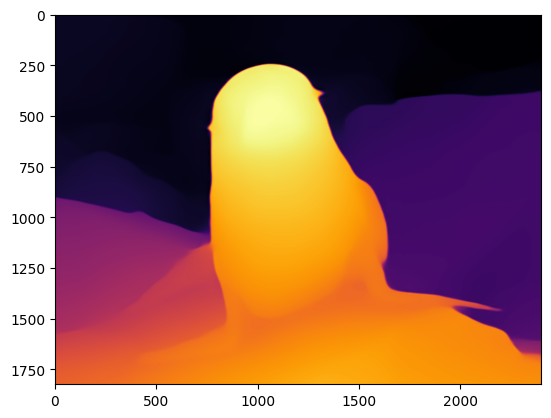

In [10]:
from matplotlib import pyplot as plt

plt.imshow(depth_color[:, :, ::-1]);

## Convert Model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). OpenVINO model conversion API should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [11]:
import openvino as ov

OV_DEPTH_ANYTHING_PATH = Path(f"{model_id}.xml")

if not OV_DEPTH_ANYTHING_PATH.exists():
    ov_model = ov.convert_model(depth_anything, example_input=image, input=[1, 3, 518, 518])
    ov.save_model(ov_model, OV_DEPTH_ANYTHING_PATH)

/content/Depth-Anything/torchhub/facebookresearch_dinov2_main/dinov2/layers/patch_embed.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
/content/Depth-Anything/torchhub/facebookresearch_dinov2_main/dinov2/layers/patch_embed.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"
/content/Depth-Anything/torchhub/facebookresearch_dinov2_main/vision_transformer.py:183

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

Now, we are ready to run OpenVINO model

### Select inference device
[back to top ⬆️](#Table-of-contents:)

For starting work, please select inference device from dropdown list.

In [12]:
device = device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [13]:
core = ov.Core()
compiled_model = core.compile_model(OV_DEPTH_ANYTHING_PATH, device.value)

### Run inference on image
[back to top ⬆️](#Table-of-contents:)

In [14]:
res = compiled_model(image)[0]

In [15]:
def get_depth_map(model_output):
    depth = model_output[0]
    depth = cv2.resize(depth, (w, h))
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

    depth = depth.astype(np.uint8)
    depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
    return depth_color


depth_color = get_depth_map(res)

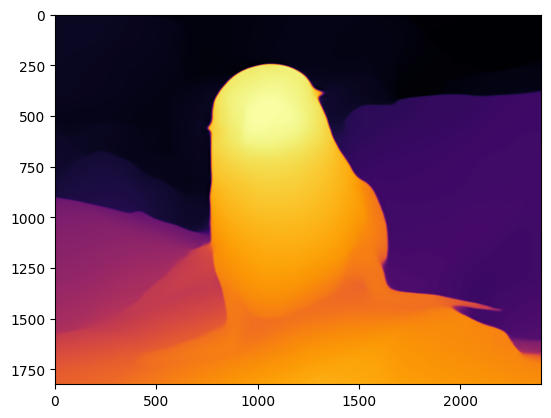

In [16]:
plt.imshow(depth_color[:, :, ::-1]);

### Run inference on video
[back to top ⬆️](#Table-of-contents:)

In [17]:
if not Path("Coco Walking in Berkeley.mp4").exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
        "./Coco Walking in Berkeley.mp4",
    )

VIDEO_FILE = "./Coco Walking in Berkeley.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 4
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_depth_anything.mp4"

Coco Walking in Berkeley.mp4:   0%|          | 0.00/877k [00:00<?, ?B/s]

In [18]:
cap = cv2.VideoCapture(str(VIDEO_FILE))
ret, image = cap.read()
if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")
input_fps = cap.get(cv2.CAP_PROP_FPS)
input_video_frame_height, input_video_frame_width = image.shape[:2]

target_fps = input_fps / ADVANCE_FRAMES
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(f"The input video has a frame width of {input_video_frame_width}, " f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps")
print(
    "The output video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 360 and runs at 30.00 fps
The output video will be scaled with a factor 0.5, have width 320,  height 180, and run at 15.00 fps


In [19]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = result * 255
    result = result.astype(np.uint8)
    result = cv2.applyColorMap(result, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

In [20]:
import time
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)


def process_video(compiled_model, video_file, result_video_path):
    # Initialize variables.
    input_video_frame_nr = 0
    start_time = time.perf_counter()
    total_inference_duration = 0

    # Open the input video
    cap = cv2.VideoCapture(str(video_file))

    # Create a result video.
    out_video = cv2.VideoWriter(
        str(result_video_path),
        FOURCC,
        target_fps,
        (target_frame_width * 2, target_frame_height),
    )

    num_frames = int(NUM_SECONDS * input_fps)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
    progress_bar = ProgressBar(total=total_frames)
    progress_bar.display()

    try:
        while cap.isOpened():
            ret, image = cap.read()
            if not ret:
                cap.release()
                break

            if input_video_frame_nr >= total_frames:
                break

            h, w = image.shape[:-1]
            input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
            input_image = transform({"image": input_image})["image"]
            # Reshape the image to network input shape NCHW.
            input_image = np.expand_dims(input_image, 0)

            # Do inference.
            inference_start_time = time.perf_counter()
            result = compiled_model(input_image)[0]
            inference_stop_time = time.perf_counter()
            inference_duration = inference_stop_time - inference_start_time
            total_inference_duration += inference_duration

            if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
                clear_output(wait=True)
                progress_bar.display()
                # input_video_frame_nr // ADVANCE_FRAMES gives the number of
                # Frames that have been processed by the network.
                display(
                    Pretty(
                        f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                        f"/{total_frames // ADVANCE_FRAMES}. "
                        f"Inference time per frame: {inference_duration:.2f} seconds "
                        f"({1/inference_duration:.2f} FPS)"
                    )
                )

            # Transform the network result to a RGB image.
            result_frame = to_rgb(convert_result_to_image(result))
            # Resize the image and the result to a target frame shape.
            result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
            image = cv2.resize(image, (target_frame_width, target_frame_height))
            # Put the image and the result side by side.
            stacked_frame = np.hstack((image, result_frame))
            # Save a frame to the video.
            out_video.write(stacked_frame)

            input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
            cap.set(1, input_video_frame_nr)

            progress_bar.progress = input_video_frame_nr
            progress_bar.update()

    except KeyboardInterrupt:
        print("Processing interrupted.")
    finally:
        clear_output()
        processed_frames = num_frames // ADVANCE_FRAMES
        out_video.release()
        cap.release()
        end_time = time.perf_counter()
        duration = end_time - start_time

        print(
            f"Processed {processed_frames} frames in {duration:.2f} seconds. "
            f"Total FPS (including video processing): {processed_frames/duration:.2f}."
            f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
        )
        print(f"Video saved to '{str(result_video_path)}'.")
    return stacked_frame

In [21]:
stacked_frame = process_video(compiled_model, VIDEO_FILE, result_video_path)

Processed 60 frames in 175.07 seconds. Total FPS (including video processing): 0.34.Inference FPS: 0.38 
Video saved to 'output/Coco Walking in Berkeley_depth_anything.mp4'.


In [22]:
def display_video(stacked_frame):
    video = Video(result_video_path, width=800, embed=True)
    if not result_video_path.exists():
        plt.imshow(stacked_frame)
        raise ValueError("OpenCV was unable to write the video file. Showing one video frame.")
    else:
        print(f"Showing video saved at\n{result_video_path.resolve()}")
        print("If you cannot see the video in your browser, please click on the " "following link to download the video ")
        video_link = FileLink(result_video_path)
        video_link.html_link_str = "<a href='%s' download>%s</a>"
        display(HTML(video_link._repr_html_()))
        display(video)

In [23]:
display_video(stacked_frame)

Showing video saved at
/content/Depth-Anything/output/Coco Walking in Berkeley_depth_anything.mp4
If you cannot see the video in your browser, please click on the following link to download the video 


## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [24]:
to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [25]:
# Fetch `skip_kernel_extension` module
if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

OV_DEPTH_ANYTHING_INT8_PATH = Path(f"{model_id}_int8.xml")

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`Nahrawy/VIDIT-Depth-ControlNet`](https://huggingface.co/datasets/Nahrawy/VIDIT-Depth-ControlNet) dataset from Hugging Face as calibration data.

In [26]:
%%skip not $to_quantize.value

import datasets

if not OV_DEPTH_ANYTHING_INT8_PATH.exists():
    subset_size = 300
    calibration_data = []
    dataset = datasets.load_dataset("Nahrawy/VIDIT-Depth-ControlNet", split="train", streaming=True).shuffle(seed=42).take(subset_size)
    for batch in dataset:
        image = np.array(batch["image"])[...,:3]
        image = image / 255.0
        image = transform({'image': image})['image']
        image = np.expand_dims(image, 0)
        calibration_data.append(image)

README.md:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.
> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
%%skip not $to_quantize.value

import nncf

if not OV_DEPTH_ANYTHING_INT8_PATH.exists():
    model = core.read_model(OV_DEPTH_ANYTHING_PATH)
    quantized_model = nncf.quantize(
        model=model,
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        calibration_dataset=nncf.Dataset(calibration_data),
    )
    ov.save_model(quantized_model, OV_DEPTH_ANYTHING_INT8_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, openvino


Output()

Let us check predictions with the quantized model using the same input data.

In [ ]:
%%skip not $to_quantize.value

def visualize_results(orig_img:Image.Image, optimized_img:Image.Image):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 model
       optimized_img (Image.Image): generated image using quantized model
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 model"
    control_title = "INT8 model"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

In [ ]:
%%skip not $to_quantize.value

image = cv2.cvtColor(cv2.imread('furseal.png'), cv2.COLOR_BGR2RGB) / 255.0
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0)

int8_compiled_model = core.compile_model(OV_DEPTH_ANYTHING_INT8_PATH, device.value)
int8_res = int8_compiled_model(image)[0]
int8_depth_color = get_depth_map(int8_res)

In [ ]:
%%skip not $to_quantize.value

visualize_results(depth_color[:, :, ::-1], int8_depth_color[:, :, ::-1])

In [ ]:
%%skip not $to_quantize.value

int8_result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_depth_anything_int8.mp4"
stacked_frame = process_video(int8_compiled_model, VIDEO_FILE, int8_result_video_path)
display_video(stacked_frame)

#### Compare model file size
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%%skip not $to_quantize.value

fp16_ir_model_size = OV_DEPTH_ANYTHING_PATH.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = OV_DEPTH_ANYTHING_INT8_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 model size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of OpenVINO FP16 and INT8 models, use [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html).

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [ ]:
import re


def get_fps(benchmark_output: str):
    parsed_output = [line for line in benchmark_output if "Throughput:" in line]
    fps = re.findall(r"\d+\.\d+", parsed_output[0])[0]
    return fps


if OV_DEPTH_ANYTHING_INT8_PATH.exists():
    benchmark_output = !benchmark_app -m $OV_DEPTH_ANYTHING_PATH -d $device.value -api async
    original_fps = get_fps(benchmark_output)
    print(f"FP16 Throughput: {original_fps} FPS")

    benchmark_output = !benchmark_app -m $OV_DEPTH_ANYTHING_INT8_PATH -d $device.value -api async
    optimized_fps = get_fps(benchmark_output)
    print(f"INT8 Throughput: {optimized_fps} FPS")
    print(f"Speed-up: {float(optimized_fps) / float(original_fps):.2f}")

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

You can apply model on own images. You can move the slider on the resulting image to switch between the original image and the depth map view.

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [ ]:
import ipywidgets as widgets

quantized_model_present = OV_DEPTH_ANYTHING_INT8_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=False,
)

use_quantized_model

In [ ]:
import numpy as np
import cv2
import tempfile

if use_quantized_model.value:
    compiled_model = core.compile_model(OV_DEPTH_ANYTHING_INT8_PATH, device.value)


def predict_depth(model, image):
    return model(image)[0]


def on_submit(image):
    original_image = image.copy()

    h, w = image.shape[:2]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    image = transform({"image": image})["image"]
    image = np.expand_dims(image, 0)

    depth = predict_depth(compiled_model, image)
    depth = cv2.resize(depth[0], (w, h), interpolation=cv2.INTER_LINEAR)

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

    colored_depth_img = Image.fromarray(colored_depth)
    tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    colored_depth_img.save(tmp.name)

    return [(original_image, colored_depth), tmp.name]

In [ ]:
# Go back to the depth-anything notebook directory
%cd ..

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/depth-anything/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=on_submit, examples_dir="Depth-Anything/assets/examples")

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/